<a href="https://www.kaggle.com/code/raghavrastogi75/classifying-cifar-using-pytorch-beginner?scriptVersionId=92129831" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing the libraries

In [1]:
import torchvision
import torch
import numpy as np
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import time
import pandas as pd
import torchvision.datasets as datasets
from IPython import display
import matplotlib.pyplot as plt
import torchvision.transforms

In [2]:
batch_size = 64
transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_ds = DataLoader(datasets.CIFAR10("data", train=True, transform=transform, download=True), batch_size=batch_size)
test_ds = DataLoader(datasets.CIFAR10("data", train=False, transform=transform, download=True), batch_size=batch_size)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
class CNNModel(nn.Module):
    
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 6 * 6, 8192),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
model = CNNModel(num_classes=10)

In [5]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

model.to(device)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=18432, out_fe

In [7]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        if epoch == 1 or epoch % 2 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [8]:
clf = train(model, optimizer,torch.nn.CrossEntropyLoss(), train_ds,test_ds, epochs=20, device=device)

train() called: model=CNNModel, opt=Adam(lr=0.001000), epochs=20, device=cuda

Epoch   1/ 20, train loss:  1.70, train acc:  0.37, val loss:  1.39, val acc:  0.49
Epoch   2/ 20, train loss:  1.28, train acc:  0.54, val loss:  1.14, val acc:  0.60
Epoch   4/ 20, train loss:  1.00, train acc:  0.65, val loss:  0.99, val acc:  0.66
Epoch   6/ 20, train loss:  0.86, train acc:  0.70, val loss:  0.92, val acc:  0.68
Epoch   8/ 20, train loss:  0.76, train acc:  0.74, val loss:  0.88, val acc:  0.70
Epoch  10/ 20, train loss:  0.69, train acc:  0.76, val loss:  0.85, val acc:  0.72
Epoch  12/ 20, train loss:  0.64, train acc:  0.78, val loss:  0.82, val acc:  0.73
Epoch  14/ 20, train loss:  0.60, train acc:  0.79, val loss:  0.80, val acc:  0.73
Epoch  16/ 20, train loss:  0.56, train acc:  0.80, val loss:  0.80, val acc:  0.74
Epoch  18/ 20, train loss:  0.52, train acc:  0.82, val loss:  0.82, val acc:  0.74
Epoch  20/ 20, train loss:  0.48, train acc:  0.83, val loss:  0.86, val acc:  0.

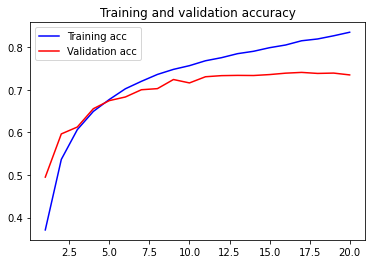

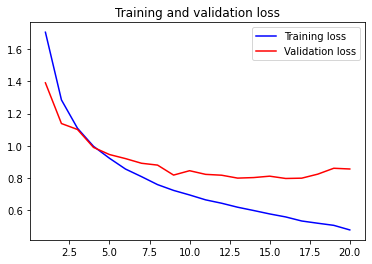

In [9]:
import matplotlib.pyplot as plt

acc = clf['acc']
val_acc = clf['val_acc']
loss = clf['loss']
val_loss = clf['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
class Logistic_Regression(nn.Module):
    
    def __init__(self,num_classes):
        
        super(Logistic_Regression, self).__init__()
        self.Linear = nn.Linear(64*64*3,num_classes)
        
    def forward(self,x):
        
        x = x.reshape(-1, 64*64*3)
        x = self.Linear(x)
        
        return x 
        
        

In [11]:
model1 = Logistic_Regression(num_classes = 10)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

model1.to(device)

Logistic_Regression(
  (Linear): Linear(in_features=12288, out_features=10, bias=True)
)

In [12]:
learningRate = 0.001
optimizer = torch.optim.SGD(model1.parameters(), lr=learningRate)

In [13]:
clf1 = train(model1, optimizer,torch.nn.CrossEntropyLoss(), train_ds,test_ds, epochs=20, device=device)

train() called: model=Logistic_Regression, opt=SGD(lr=0.001000), epochs=20, device=cuda

Epoch   1/ 20, train loss:  1.88, train acc:  0.35, val loss:  1.91, val acc:  0.32
Epoch   2/ 20, train loss:  1.80, train acc:  0.38, val loss:  1.89, val acc:  0.33
Epoch   4/ 20, train loss:  1.77, train acc:  0.40, val loss:  1.88, val acc:  0.34
Epoch   6/ 20, train loss:  1.75, train acc:  0.41, val loss:  1.87, val acc:  0.34
Epoch   8/ 20, train loss:  1.73, train acc:  0.41, val loss:  1.86, val acc:  0.35
Epoch  10/ 20, train loss:  1.72, train acc:  0.42, val loss:  1.86, val acc:  0.35
Epoch  12/ 20, train loss:  1.72, train acc:  0.42, val loss:  1.86, val acc:  0.35
Epoch  14/ 20, train loss:  1.71, train acc:  0.42, val loss:  1.85, val acc:  0.35
Epoch  16/ 20, train loss:  1.70, train acc:  0.42, val loss:  1.85, val acc:  0.36
Epoch  18/ 20, train loss:  1.70, train acc:  0.42, val loss:  1.85, val acc:  0.36
Epoch  20/ 20, train loss:  1.69, train acc:  0.43, val loss:  1.85, va

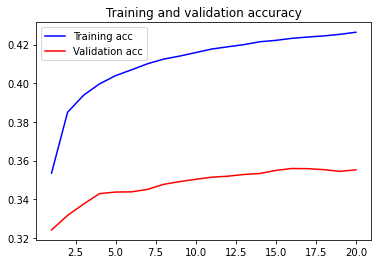

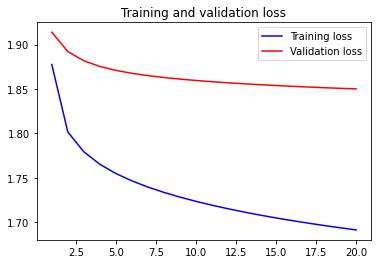

In [14]:
acc = clf1['acc']
val_acc = clf1['val_acc']
loss = clf1['loss']
val_loss = clf1['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()